## Script 1, Saloni

#### (Preprocessing)

### Article Clean Up

In [ ]:
!pip install pyarrow

In [ ]:
import pandas as pd
import pyarrow
import re

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pip install progress

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9612 sha256=70090f86fe36cebd0e054aaa6de843b91e02194c8571d18b216b16aa90b5f347
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


In [ ]:
pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=60fa173c483f0222ef7ae252972d1a3c76ae834cd8275367a54c5afe07d7fac4
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from pandarallel import pandarallel
import multiprocessing
from progress.bar import Bar

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=Bar())

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Preprocessing

#### Load Data

In [ ]:
df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')

In [ ]:
df_news_final_project.head()

,url,date,language,title,text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor..."
2,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,2020-03-13,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articolo\nHome page\n\n\nAttualitÃ \n\n\nAmbiente\nCronaca\nCronaca Locale\nCultura\nEconomia\nEuropa\nMedia\nIstruzione\nMondo\nPolitica\nSalute\nReligione\nSocietÃ \nScienza e Tecnologia\nTribuna Libera\n\n\tDi' la tua\n\n\nTempo Libero\n\n\nGossip\nRedazionali\nConcorsi\nCinema\nFame&Tulipani\nIncredibile ma vero!\nLa vignetta del giorno...
3,http://www.desototimes.com/news/child-actor-claude-jarman-jr-looks-back-on-his-movie-career-during-the-golden-days/article_0b310fae-e767-11ec-982e-a380305dda2f.html,2022-06-09,en,Child actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com,\nChild actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com\nSkip to main content\n\nYou have permission to edit this article.\n\n Edit\nClose\n\nHome\nNews\n\n\nNews\n\nLocal News\n\nFaith & Worship\n\n\nBusiness\nSports\n\n\nSports\n\nLocal Sports\n\nOutdoor Report\n\nOpinion\n\n\nOpinion\n\nLetters to the Editor\n\nSubmit a Letters to the Editor\n\n\nObituaries\nLifestyle\n\n\nLifestyle\n\nFeatures\n\nCommunity Calendar\n\n...
4,http://www.millenniumpost.in/big-stories/ai-express-aircraft-skids-off-runaway-in-kozhikode-rescue-ops-on-414926,2020-08-07,en,Two dead as AI Express flight skids off Kozhikode airport,Two dead as AI Express flight skids off Kozhikode airportTopLoginSubscribeToggle navigationFeaturesDelhiKolkataNationOpinionEditorialBusinessSportsSunday PostBeyond BygoneEpic PowerIn RetrospectGlobal EyeInlandRoutesBeaconInsightGame OnSafariTrendingCandid TalkGastronomyFact FilesMapping the states of IndiaX/sunday-post/beyond-bygone/sunday-post/epic-power/fact-files/ians-feeds/sundaypost/in-retrospect/mapping-the-states-of-india/puja-special/Reminiscence/sponsored/sundaypost/global-eye/feat...


#### Initial Data Analysis

In [ ]:
df = df_news_final_project[df_news_final_project['language'] == 'en']
df.shape

(200435, 5)

In [ ]:
df.nunique()

url         200435
date          1493
language         1
title       141645
text        199735
dtype: int64

In [ ]:
df.shape

(200435, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200435 entries, 0 to 200434
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200435 non-null  object
 1   date      200435 non-null  object
 2   language  200435 non-null  object
 3   title     200435 non-null  object
 4   text      200435 non-null  object
dtypes: object(5)
memory usage: 9.2+ MB


#### Drop Duplicates

In [ ]:
df = df.drop_duplicates(subset=['title'], keep='first')

In [ ]:
df.nunique()

url         141645
date          1493
language         1
title       141645
text        141645
dtype: int64

#### Data Sampling

In [ ]:
#df = df.sample(n=1000, random_state=42)

#### Find Average Word, Sentence, and Article Length

In [ ]:
text_doc = df['text']
text_doc_word_lengths = text_doc.str.len()
avg_word_len_before = text_doc_word_lengths.mean()

In [ ]:
sentences = text_doc.str.split('[.!?]')
sentence_lengths = sentences.apply(len)
avg_sent_len_before = sentence_lengths.mean()

In [ ]:
# Compute the mean article length
word_counts = text_doc.apply(lambda x: len(x.split()))
article_lengths = word_counts.sum()
article_len_before = article_lengths / len(text_doc)

In [ ]:
print(f"Average word length: {avg_word_len_before} characters")
print(f"Average sentence length: {avg_sent_len_before} words")
print(f"Average article length: {article_len_before} words")

Average word length: 9622.281725440362 characters
Average sentence length: 58.59678068410463 words
Average article length: 1325.2218998199726 words


#### Word Cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
initial_texts = df['text']

In [ ]:
import matplotlib.pyplot as plt

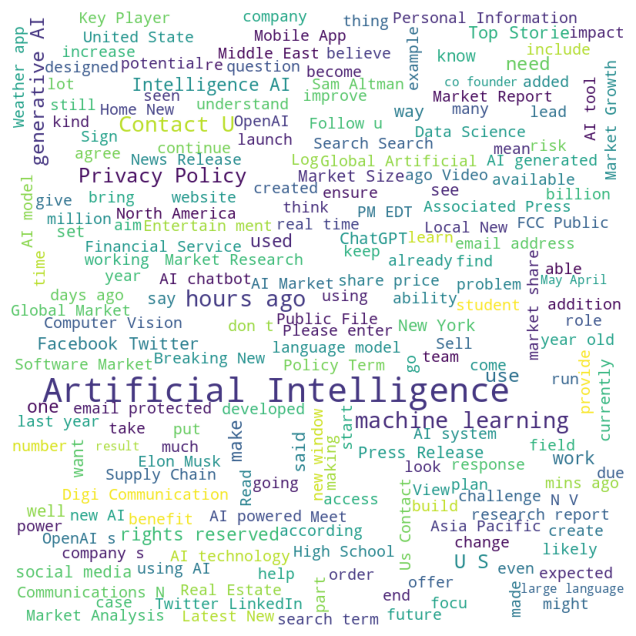

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(initial_texts))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Text Frequency Over Time

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

texts_per_month = df.resample('M').count()

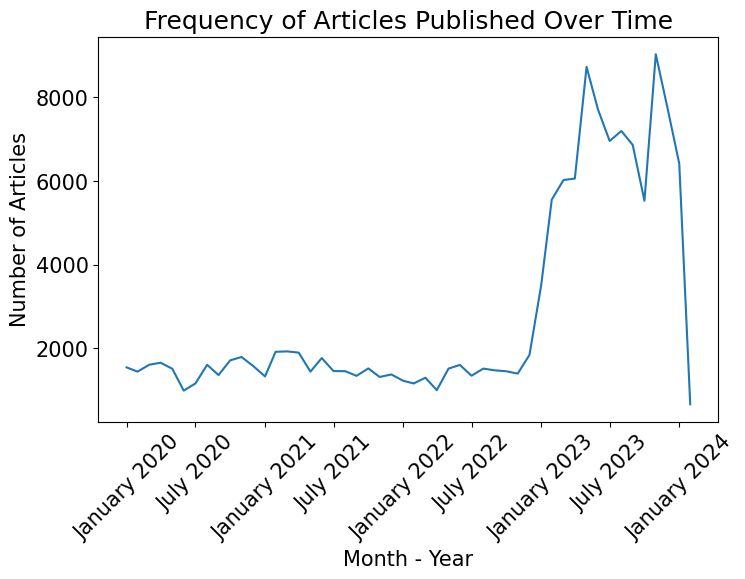

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(texts_per_month.index, texts_per_month['text'])
plt.title('Frequency of Articles Published Over Time')
plt.rcParams.update({'font.size': 15})

tick_locations = texts_per_month.index[::6]
tick_labels = [date.strftime('%B %Y') for date in tick_locations]
plt.xticks(tick_locations, tick_labels)

plt.xlabel('Month - Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

#### Clean Text

##### Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [ ]:
def newline_tab(text):
    # Replace newline characters with spaces
    text = re.sub(r'\n', ' ', text)
    # Replace tab characters with spaces
    text = re.sub(r'\t', ' ', text)
    return text

In [ ]:
#def article_phrase(text, phrases, max_words_after_phrase=60):
#    for phrase in phrases:
#        pattern = re.compile(r'(' + re.escape(phrase) + r')\W.*', re.IGNORECASE | re.DOTALL)
 #       match = re.search(pattern, text)

  #      if match:
   #         pos = match.start(1)
    #        words_after_phrase = len(re.findall(r'\w+', text[pos:]))

     #       if words_after_phrase <= max_words_after_phrase:
      #          text = text[:pos].strip()
    #return text

In [ ]:
common_phrases = [
    "Skip to content",
    "Skip to main content",
    "Related Articles",
    "Related Stories",
    "Advertisement",
    "Sponsored Content",
    "Share this",
    "Share on",
    "Comments",
    "Leave a Reply",
    "Subscribe",
    "Sign up",
    "About the Author",
    "Author Bio",
    "Copyright",
    "All rights reserved",
    "Source",
    "Originally published on",
    "The above press release",
    "READ MORE",
    "Read more",
    "Contact Us",
    "Read More",
    "Copyright",
    "To see more",
    "For additional information",
    "For more information"
]

In [ ]:
def article_phrase(_text, endings, position_ratio=0.75):
    for ending in endings:
        pattern = re.compile(r'(' + re.escape(ending) + r')\W.*', re.IGNORECASE | re.DOTALL)
        match = re.search(pattern, _text)

        if match:
            pos = match.start(1)

            if pos >= len(_text) * position_ratio:
                _text = _text[:pos].strip()  # Remove the ending and everything after it
            else:
                _text = _text[:pos] + _text[pos+len(ending):]  # Remove only the ending
    return _text

In [ ]:
def noisy_lines(text):
    for phrase in common_phrases:
        text = re.sub(phrase, ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
def remove_words_sentences_by_length(text, max_word_length=25, min_sentence_length=5, max_sentence_length=45):
    # Filter by word length (did not remove small ones, want to keep acronyms like AI and IT)
    filtered_words = [word for word in text.split() if len(word) <= max_word_length]
    text = ' '.join(filtered_words)

    sentences = sent_tokenize(text)
    filtered_sentences = [s for s in sentences if min_sentence_length <= len(s.split()) <= max_sentence_length]

    return ' '.join(filtered_sentences)

In [ ]:
def remove_unncessary(text):
    # Remove special characters and stopwords
    words = [re.sub(r'[^\w\s]', '', word) for word in text.split() if word.lower() not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text.strip()

In [ ]:
df['cleaned_text'] = df['text'].apply(newline_tab)

In [ ]:
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda t: article_phrase(t, endings=common_phrases, position_ratio=0.75))

In [ ]:
df['cleaned_text'] = df['cleaned_text'].apply(noisy_lines)

In [ ]:
df['cleaned_text'] = df['cleaned_text'].apply(
    lambda t: remove_words_sentences_by_length(t, max_word_length=25,
                                               min_sentence_length=5, max_sentence_length=45))

In [ ]:
df['important_words'] = df['cleaned_text'].apply(remove_unncessary)

In [ ]:
df.head()

,url,language,title,text,cleaned_text,important_words
date,,,,,,
2020-02-26,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...","It provides an in-depth analysis of different attributes of industries such as trends, SWOT analysis, policies, and clients operating in several regions. Legal Tech companies are generally startups founded with the purpose of disrupting the traditionally conservative legal market. Each of these regions is analysed on the basis of market findings across major countries in these regions for a macro-level understanding of the market.Important Features that are under Offering and Key Highlights ...",provides indepth analysis different attributes industries trends SWOT analysis policies clients operating several regions Legal Tech companies generally startups founded purpose disrupting traditionally conservative legal market regions analysed basis market findings across major countries regions macrolevel understanding marketImportant Features Offering Key Highlights Reports Detailed overview LegalTech Artificial Intelligence Market Changing market dynamics LegalTech Artificial Intellige...
2020-02-27,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve it tweak trouble ranges problem kid...
2020-03-13,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articolo\

#### Lemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [ ]:
#df['important_words'] = df['important_words'].apply(lemmatize_text)
df['important_words'] = df['important_words'].apply(remove_unncessary)

##### LATER:
##### - Discard irrelevant articles by Loooking at Topics
##### - N-grams: consider for topic modeling

In [ ]:
import os
import pandas as pd

# Define the directory path
directory_path = '/content/drive/MyDrive/NLP/Saloni/'

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created successfully.")
else:
    print(f"Directory '{directory_path}' already exists.")

# Assuming you have a DataFrame called df containing your data
# Save it as a Parquet file
df.to_parquet(os.path.join(directory_path, 'preprocessed_news_final_1.parquet'))


Directory '/content/drive/MyDrive/NLP/Saloni/' created successfully.


In [ ]:
import pandas as pd

# Read the Parquet file into a DataFrame
df = pd.read_parquet('/content/preprocessed_news_final_1.parquet')

# Display the first few rows of the DataFrame
df.head()


,url,language,title,text,cleaned_text,important_words
date,,,,,,
2020-02-26,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...","It provides an in-depth analysis of different attributes of industries such as trends, SWOT analysis, policies, and clients operating in several regions. Legal Tech companies are generally startups founded with the purpose of disrupting the traditionally conservative legal market. Each of these regions is analysed on the basis of market findings across major countries in these regions for a macro-level understanding of the market.Important Features that are under Offering and Key Highlights ...",provides indepth analysis different attributes industries trends SWOT analysis policies clients operating several regions Legal Tech companies generally startups founded purpose disrupting traditionally conservative legal market regions analysed basis market findings across major countries regions macrolevel understanding marketImportant Features Offering Key Highlights Reports Detailed overview LegalTech Artificial Intelligence Market Changing market dynamics LegalTech Artificial Intelligen...
2020-02-27,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve tweak trouble ranges problem kid cor...
2020-03-13,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articol

In [ ]:
df.to_parquet('/content/drive/MyDrive/NLP/Saloni/preprocessed_news_final_1.parquet')

In [ ]:
df.to_parquet('preprocessed_news_final_1.parquet')

In [ ]:
import os

# Specify the directory path
directory_path = '/content/drive/MyDrive/NLP/Saloni/'

# Specify the file name
file_name = 'preprocessed_news_final_1.parquet'

# Construct the full file path
file_path = os.path.join(directory_path, file_name)

# Check if the file exists
if os.path.exists(file_path):
    print(f"The file {file_name} exists in the directory {directory_path}.")
else:
    print(f"The file {file_name} does not exist in the directory {directory_path}.")


The file preprocessed_news_final_1.parquet exists in the directory /content/drive/MyDrive/NLP/Saloni/.


In [ ]:
df.shape

(141645, 6)

In [ ]:
df.head(15)

,url,language,title,text,cleaned_text,important_words
date,,,,,,
2020-02-26,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...","It provides an in-depth analysis of different attributes of industries such as trends, SWOT analysis, policies, and clients operating in several regions. Legal Tech companies are generally startups founded with the purpose of disrupting the traditionally conservative legal market. Each of these regions is analysed on the basis of market findings across major countries in these regions for a macro-level understanding of the market.Important Features that are under Offering and Key Highlights ...",provides indepth analysis different attributes industries trends SWOT analysis policies clients operating several regions Legal Tech companies generally startups founded purpose disrupting traditionally conservative legal market regions analysed basis market findings across major countries regions macrolevel understanding marketImportant Features Offering Key Highlights Reports Detailed overview LegalTech Artificial Intelligence Market Changing market dynamics LegalTech Artificial Intelligen...
2020-02-27,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve tweak trouble ranges problem kid cor...
2020-03-13,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articol

In [ ]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /content


## 2. Initial Exploratory Data Analysis

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
import seaborn as sns

#### Average

In [ ]:
# Calculate average word length for important words
important_words = df['important_words']
important_word_lengths = important_words.str.len()
avg_word_len_after_imp = important_word_lengths.mean()

In [ ]:
# Calculate average word length for all words
cleaned_text = df['cleaned_text']
cleaned_word_lengths = cleaned_text.str.len()
avg_word_len_after = cleaned_word_lengths.mean()

In [ ]:
# Calculate average sentence length
sentences = cleaned_text.str.split('[.!?]')
sentence_lengths = sentences.apply(len)
avg_sent_len_after = sentence_lengths.mean()

In [ ]:
# Compute the mean article length
word_counts = cleaned_text.apply(lambda x: len(x.split()))
article_lengths = word_counts.sum()
article_len_after = article_lengths / len(cleaned_text)

In [ ]:
print(f"Average word length for more important words: {avg_word_len_after_imp} characters")
print(f"Average word length for all words: {avg_word_len_after} characters")
print(f"Average sentence length: {avg_sent_len_after} words")
print(f"Average article length: {article_len_after} words")

Average word length for more important words: 2503.4669631826046 characters
Average word length for all words: 3354.0048925129727 characters
Average sentence length: 30.992417663878005 words
Average article length: 526.543308976667 words


#### Word Cloud

In [ ]:
cleaned_texts = df['important_words']

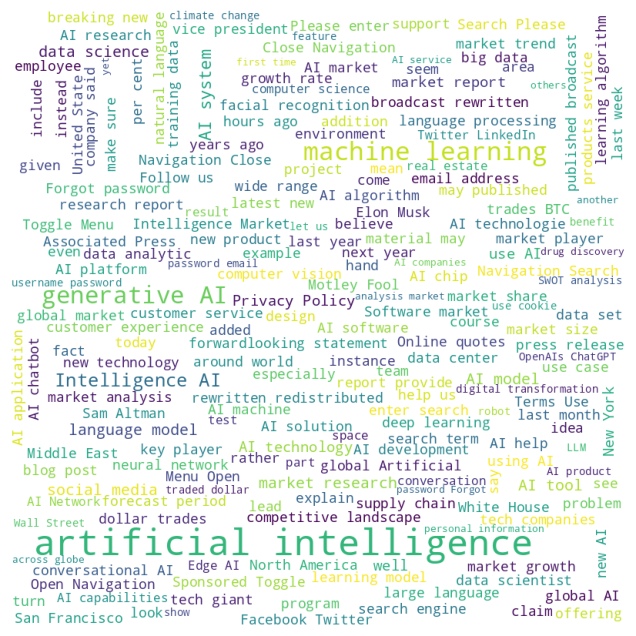

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cleaned_texts))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()